In [1]:
import tkinter as tk
import os
import cv2
import sys
from PIL import Image, ImageTk

fileName = os.environ['ALLUSERSPROFILE'] + "\WebcamCap.txt"
cancel = False

def prompt_ok(event = 0):
    global cancel, button, button1, button2
    cancel = True

    button.place_forget()
    button1 = tk.Button(mainWindow, text="Good Image!", command=saveAndExit)
    button2 = tk.Button(mainWindow, text="Try Again", command=resume)
    button1.place(anchor=tk.CENTER, relx=0.2, rely=0.9, width=150, height=50)
    button2.place(anchor=tk.CENTER, relx=0.8, rely=0.9, width=150, height=50)
    button1.focus()

def saveAndExit(event = 0):
    global prevImg

    if (len(sys.argv) < 2):
        filepath = "imageCap.png"
    else:
        filepath = sys.argv[1]

    print ("Output file to: " + filepath)
    prevImg.save(filepath)
    mainWindow.quit()


def resume(event = 0):
    global button1, button2, button, lmain, cancel

    cancel = False

    button1.place_forget()
    button2.place_forget()

    mainWindow.bind('<Return>', prompt_ok)
    button.place(bordermode=tk.INSIDE, relx=0.5, rely=0.9, anchor=tk.CENTER, width=300, height=50)
    lmain.after(10, show_frame)

def changeCam(event=0, nextCam=-1):
    global camIndex, cap, fileName

    if nextCam == -1:
        camIndex += 1
    else:
        camIndex = nextCam
    del(cap)
    cap = cv2.VideoCapture(camIndex)

    #try to get a frame, if it returns nothing
    success, frame = cap.read()
    if not success:
        camIndex = 0
        del(cap)
        cap = cv2.VideoCapture(camIndex)

    f = open(fileName, 'w')
    f.write(str(camIndex))
    f.close()

try:
    f = open(fileName, 'r')
    camIndex = int(f.readline())
except:
    camIndex = 0

cap = cv2.VideoCapture(camIndex)
capWidth = cap.get(3)
capHeight = cap.get(4)

success, frame = cap.read()
if not success:
    if camIndex == 0:
        print("Error, No webcam found!")
        sys.exit(1)
    else:
        changeCam(nextCam=0)
        success, frame = cap.read()
        if not success:
            print("Error, No webcam found!")
            sys.exit(1)


mainWindow = tk.Tk(screenName="Camera Capture")
mainWindow.resizable(width=False, height=False)
mainWindow.bind('<Escape>', lambda e: mainWindow.quit())
lmain = tk.Label(mainWindow, compound=tk.CENTER, anchor=tk.CENTER, relief=tk.RAISED)
button = tk.Button(mainWindow, text="Capture", command=prompt_ok)
button_changeCam = tk.Button(mainWindow, text="Switch Camera", command=changeCam)

lmain.pack()
button.place(bordermode=tk.INSIDE, relx=0.5, rely=0.9, anchor=tk.CENTER, width=300, height=50)
button.focus()
button_changeCam.place(bordermode=tk.INSIDE, relx=0.85, rely=0.1, anchor=tk.CENTER, width=150, height=50)

def show_frame():
    global cancel, prevImg, button

    _, frame = cap.read()
    cv2image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)

    prevImg = Image.fromarray(cv2image)
    imgtk = ImageTk.PhotoImage(image=prevImg)
    lmain.imgtk = imgtk
    lmain.configure(image=imgtk)
    if not cancel:
        lmain.after(10, show_frame)

show_frame()
mainWindow.mainloop()

Output file to: --ip=127.0.0.1


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\harit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py", line 2298, in save
    format = EXTENSION[ext]
KeyError: '.1'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\harit\AppData\Local\Temp\ipykernel_15104\1698361591.py", line 30, in saveAndExit
    prevImg.save(filepath)
  File "C:\Users\harit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py", line 2300, in save
    raise ValueError(f"unknown file extension: {ext}") from e
ValueError: unknown file extension: .1


In [2]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

In [3]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
  
  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  
  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)
  
  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)


In [4]:
def removeBlack(estimator_labels, estimator_cluster):
  
  
  # Check for black
  hasBlack = False
  
  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)
  
  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)
   
  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
  
    
    # Check if the color is [0,0,0] that if it is black 
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster 
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break
      
   
  return (occurance_counter,estimator_cluster,hasBlack)
    
    
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):
  
  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None
  
  # Output list variable to return
  colorInformation = []
  
  
  #Check for Black
  hasBlack =False
  
  # If a mask has be applied, remove th black
  if hasThresholding == True:
    
    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black
    
  else:
    occurance_counter = Counter(estimator_labels)
 
  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values())
  
 
  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    index = (int(x[0]))
    
    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index
    
    # Get the color number into a list
    color = estimator_cluster[index].tolist()
    
    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)
    
    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }
    
    # Add the dictionary to the list
    colorInformation.append(colorInfo)
    
      
  return colorInformation 

In [5]:
def extractDominantColor(image,number_of_colors=1,hasThresholding=False):
  
  # Quick Fix Increase cluster counter to neglect the black(Read Article) 
  if hasThresholding == True:
    number_of_colors +=1
  
  # Taking Copy of the image
  img = image.copy()
  
  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)
  
  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)
  
  # Fit the image
  estimator.fit(img)
  
  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation
  
  

In [6]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")
  
  top_x = 0
  for x in colorInformation:    
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))
    if((color[0] > 45) and color[0] <100):
      print("")
      print("---------------Deep---------------")
      print("")
      print("LIQUID FOUNDATION")
      print("       310 SUN BEIGE , 330 TOFFEE")
      print("-----------------------------------")
      print("FOUNDATION STICK")
      print("       330 TOFFEE, 355 COCONUT")
      print("-----------------------------------")
      print("PRESSED POWDER")
      print("       310 SUN BEIGE , 330 TOFFEE")
      print("-----------------------------------")
      print("CONCEALER")
      print("       30 CAFE , 35 DEEP")
      print("-----------------------------------")
    elif((color[0] > 100) and (color[0] < 120)):
      print("")
      print("---------------------------------------Medium-Tan---------------------------------------")
      print("")
      print("LIQUID FOUNDATION")
      print("       220 NATURAL BEIGE , 222 TRUE BEIGE , 228 SOFT TAN , 230 NATURAL BUFF, 238 RICH TAN")
      print("-------------------------------------------------------------------------------------------")
      print("FOUNDATION STICK")
      print("       220 NATURAL BEIGE , 235 PURE BEIGE , 220 NATURAL BEIGE")
      print("-------------------------------------------------------------------------------------------")
      print("PRESSED POWDER")
      print("       220 NATURAL BEIGE , 222 TRUE BEIGE/235 PURE BEIGE , 230 NATURAL BUFF")
      print("-------------------------------------------------------------------------------------------")
      print("CONCEALER")
      print("       25 MEDUIM")
      print("-------------------------------------------------------------------------------------------")
    else:
      print("")
      print("---------------------------------Light---------------------------------")
      print("")
      print("LIQUID FOUNDATION")
      print("       120 CLASSIC IVORY , 125 NUDE BEIGE, 128 WARM NUDE")
      print("------------------------------------------------------------------------")
      print("FOUNDATION STICK")
      print("       115 IVORY/120 CLASSIC IVORY , 110 POPCLEAIN , 120 CLASSIC IVORY")
      print("------------------------------------------------------------------------")
      print("PRESSED POWDER")
      print("       120 CLASSIC IVORY , 130 BUFF BEIGE")
      print("------------------------------------------------------------------------")
      print("CONCEALER")
      print("       20 SAND")
      print("------------------------------------------------------------------------")
    

    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x
  return color_bar

In [7]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

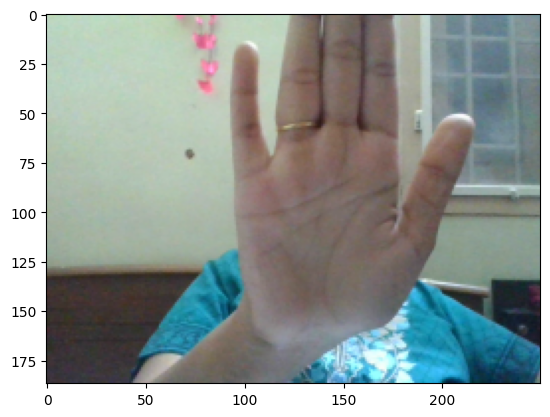

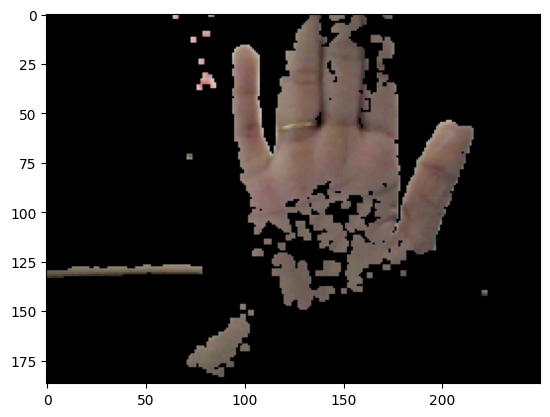

Color Information
{'cluster_index': 0,
 'color': [125.7009803921555, 104.85726643598564, 96.36034217608777],
 'color_percentage': 1.0}

Color Bar

---------------------------------Light---------------------------------

LIQUID FOUNDATION
       120 CLASSIC IVORY , 125 NUDE BEIGE, 128 WARM NUDE
------------------------------------------------------------------------
FOUNDATION STICK
       115 IVORY/120 CLASSIC IVORY , 110 POPCLEAIN , 120 CLASSIC IVORY
------------------------------------------------------------------------
PRESSED POWDER
       120 CLASSIC IVORY , 130 BUFF BEIGE
------------------------------------------------------------------------
CONCEALER
       20 SAND
------------------------------------------------------------------------


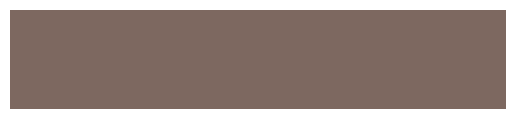

In [8]:
image =  frame

# Resize image to a width of 250
image = imutils.resize(image,width=250)

#Show image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()


# Apply Skin Mask
skin = extractSkin(image)

plt.imshow(cv2.cvtColor(skin,cv2.COLOR_BGR2RGB))
plt.show()



# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors 
dominantColors = extractDominantColor(skin,hasThresholding=True)




#Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)


#Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.axis("off")
plt.imshow(colour_bar)
plt.show()


